In [1]:
import os
import argparse
import glob
import time
import random
import logging
import numpy as np
import pandas as pd
import multiprocessing as mp
import euclidean_distance
from scipy import integrate
from collections import namedtuple
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
# from MultiProcessingLog import MultiProcessingLog

logger = logging.getLogger()

In [3]:
from logging.handlers import RotatingFileHandler
import multiprocessing, threading, logging, sys, traceback

class MultiProcessingLog(logging.Handler):
    def __init__(self, name, mode, maxsize, rotate):
        logging.Handler.__init__(self)

        self._handler = RotatingFileHandler(name, mode, maxsize, rotate)
        self.queue = multiprocessing.Queue(-1)

        t = threading.Thread(target=self.receive)
        t.daemon = True
        t.start()

    def setFormatter(self, fmt):
        logging.Handler.setFormatter(self, fmt)
        self._handler.setFormatter(fmt)

    def receive(self):
        while True:
            try:
                record = self.queue.get()
                self._handler.emit(record)
            except (KeyboardInterrupt, SystemExit):
                raise
            except EOFError:
                break
            except:
                traceback.print_exc(file=sys.stderr)

    def send(self, s):
        self.queue.put_nowait(s)

    def _format_record(self, record):
        # ensure that exc_info and args
        # have been stringified.  Removes any chance of
        # unpickleable things inside and possibly reduces
        # message size sent over the pipe
        if record.args:
            record.msg = record.msg % record.args
            record.args = None
        if record.exc_info:
            dummy = self.format(record)
            record.exc_info = None

        return record

    def emit(self, record):
        try:
            s = self._format_record(record)
            self.send(s)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)

    def close(self):
        self._handler.close()
        logging.Handler.close(self)


In [7]:
# Define args:
source_dir = '/Users/Joel/shares/workShareJoel/20190705_popcon_test'
target_dir = '/Users/Joel/shares/workShareJoel/20190705_popcon_test/test_output'
centroid_object = 'Nuclei'
main_object = 'Nuclei'

In [15]:
def calculate_popcon_features(
        target_dir,
        features_filename, metadata_filename,
        centroid_name_y, centroid_name_x,
        image_size_y=2560, image_size_x=2160,
        downsample_factor=1,
        object_name="Cells",
        radii=[100,200,300]):

    logger.info('Calculating popcon features')
    logger.info('features_filename: %s', features_filename)
    logger.info('metadata_filename: %s', metadata_filename)
    logger.info('target_dir: %s', target_dir)
    logger.info('downsample_factor: %d', downsample_factor)
    logger.info('object_name: %s', object_name)
    logger.info('radii: {}'.format(radii))
    logger.info('centroid_name_y: %s',centroid_name_y)
    logger.info('centroid_name_x: %s',centroid_name_x)

    image_shape = (image_size_y, image_size_x)
    metadata = pd.read_csv(
        metadata_filename,
        usecols=['mapobject_id', 'well_pos_y', 'well_pos_x'])
    features = pd.read_csv(
        features_filename,
        usecols=['mapobject_id', centroid_name_y, centroid_name_x])

#     logger.debug('Extracting well_shape from metadata_file:')
#     well_shape = (
#         int(image_size_y * (1 + metadata.well_pos_y.max())),
#         int(image_size_x * (1 + metadata.well_pos_x.max()))
#     )
#     logger.info('Well shape is {}'.format(well_shape))

#     global_coordinates = convert_local_to_global_centroids(
#         features, metadata, image_shape,
#         centroid_name_y, centroid_name_x
#     )
# #     print(global_coordinates.df)
#     crowding = get_crowding(
#         global_coordinates.df, well_shape,
#         global_coordinates.centroid_name_y,
#         global_coordinates.centroid_name_x,
#         object_name)

#     logger.info('Finished crowding calculation for: {}'.format(features_filename))

#     popcon_features = global_coordinates.df.merge(
#         crowding,on='mapobject_id')
#     print('Finished')

#     lcc = get_local_cell_crowding(
#         global_coordinates.df, well_shape,
#         global_coordinates.centroid_name_y,
#         global_coordinates.centroid_name_x,
#         object_name)

#     popcon_features = popcon_features.merge(
#         lcc,on='mapobject_id')

#     for radius in radii:
#         logger.debug(
#             'At Radius {}, calculating object density for: {}'.format(radius, features_filename)
#         )
#         local_density = get_local_density(
#             global_coordinates.df,
#             well_shape, downsample_factor,
#             global_coordinates.centroid_name_y,
#             global_coordinates.centroid_name_x,
#             object_name,radius=int(radius))

#         logger.info('At Radius {}, finished density calculation for: {}'.format(radius,features_filename))

#         popcon_features = popcon_features.merge(
#             local_density,on='mapobject_id')

#     f = os.path.basename(features_filename).replace('feature-values','popcon')
#     output_file = os.path.join(os.path.expanduser(target_dir),f)

#     popcon_features.to_csv(output_file,index=False,index_label=False)

#     return



In [16]:
def convert_local_to_global_centroids(
        local_features, local_metadata, image_shape,
        centroid_name_y, centroid_name_x):

    logger.debug('Converting to global coordinates')
    global_centroids = namedtuple(
        'global_centroids', ['df','centroid_name_y','centroid_name_x']
    )

    global_centroids.centroid_name_y = centroid_name_y.replace(
        'Morphology_Local','Morphology_Global')
    global_centroids.centroid_name_x = centroid_name_x.replace(
        'Morphology_Local','Morphology_Global')

    local = local_features.merge(local_metadata, on='mapobject_id')
    d = []
    for row in local.itertuples():
        d.append({
            'mapobject_id': row.mapobject_id,
            global_centroids.centroid_name_y: getattr(row, centroid_name_y) +
                row.well_pos_y * image_shape[0],
            global_centroids.centroid_name_x: getattr(row, centroid_name_x) +
                row.well_pos_x * image_shape[1]
        })

    global_centroids.df = pd.DataFrame(d)
    return(global_centroids)

In [17]:
def get_crowding(
        features, image_shape,
        global_centroid_name_y, global_centroid_name_x,
        object_type):
    """
    Returns a DataFrame containing the mapobject_id and the object
    crowding with column label "Crowding" + object_type
    """

    maximal_distance = np.sqrt(float(image_shape[0])**2 +
                               float(image_shape[1])**2)

    crowding_list = []
    for row in features.itertuples():
        logger.debug('Calculating crowding for cell {}'.format(row.Index))
        # find distances from current cell to all other cells
        real_distances = cdist(
            np.column_stack(
                [getattr(row, global_centroid_name_y),
                 getattr(row, global_centroid_name_x)]
            ),
            np.column_stack(
                [getattr(features.drop(row.Index), global_centroid_name_y),
                 getattr(features.drop(row.Index), global_centroid_name_x)]
            ),
            metric='euclidean')

        # find expected mean distance to all other points in the domain
        expected_mean_distance = mean_euclidean_distance(
            getattr(row, global_centroid_name_x),
            getattr(row, global_centroid_name_y),
            int(image_shape[1]),
            int(image_shape[0]))

        # invert real distances to get crowding
        inverse_real_distances = np.divide(
            np.ones_like(real_distances),
            real_distances)

        # subtract the expected crowding and normalise by maximal distance
        crowding = maximal_distance * \
            (np.mean(inverse_real_distances) -
                (1.0 / expected_mean_distance))

        crowding_list.append({
            "Crowding_" + object_type: crowding,
            'mapobject_id': row.mapobject_id})

    return(pd.DataFrame(crowding_list))

def mean_euclidean_distance(x_i, y_i, x_max, y_max):
    """
    Returns the mean euclidean distance from a point (x_i,y_i) to
    all other points in the rectangle with vertices (0,0),(x_max,y_max)
    """

    d = integrate.dblquad(lambda x, y: euclidean_distance.metric(x,y,x_i,y_i),
                          0, y_max,
                          0, x_max)

    area = x_max * y_max
    return d[0] / area

def get_local_density(
        features, image_shape, downsample_factor,
        global_centroid_name_y, global_centroid_name_x,
        object_type, radius=100):
    """
    Returns a DataFrame containing the mapobject_id and the object
    density with column label "LocalDensity" + object_type + radius
    """

    resized_image_shape = (int(image_shape[0] / downsample_factor),
                           int(image_shape[1] / downsample_factor))
    logger.debug('resized_image_shape: {}'.format(resized_image_shape))

    dot_image = np.zeros(shape=resized_image_shape, dtype=np.float64)
    feature_name = "LocalDensity_" + object_type + "_" + str(radius)

    for row in features.itertuples():
        logger.debug('Generating dot_image for object {}'.format(row.Index))
        dot_image[
            int(getattr(row, global_centroid_name_y) / downsample_factor),
            int(getattr(row, global_centroid_name_x) / downsample_factor)] = 1

    logger.debug('Blurring dot_image with radius {}'.format(radius))
    gaussian_image = gaussian_filter(
        dot_image,
        sigma=int(radius / downsample_factor))

    d = []
    for row in features.itertuples():
        logger.debug('Measuring blurred image for object {} at radius {}'.format(row.Index, radius))
        d.append({
            feature_name: gaussian_image[
                int(getattr(row, global_centroid_name_y) / downsample_factor),
                int(getattr(row, global_centroid_name_x) / downsample_factor)],
            'mapobject_id': row.mapobject_id})
    return(pd.DataFrame(d))


In [18]:
features_files = [
    os.path.basename(full_path) for full_path in
    glob.glob(
        source_dir +
        '/*' +
        main_object +
        '_feature-values.csv')]
metadata_files = [f.replace('feature-values','metadata')
                  for f in features_files]

features_paths = [os.path.join(source_dir,f) for f in features_files]
metadata_paths = [os.path.join(source_dir,f) for f in metadata_files]

local_centroid_name_y = 'Morphology_Local_Centroid_y'
local_centroid_name_x = 'Morphology_Local_Centroid_x'


calculate_popcon_features(target_dir,
        features_paths[0], metadata_paths[0],
        local_centroid_name_y, local_centroid_name_x,
        image_size_y=2560, image_size_x=2160,
        downsample_factor=4,
        object_name=main_object,
        radii=[300, 500])



Finished


In [57]:
def calculate_edge(features_filename, metadata_filename,
        centroid_name_y, centroid_name_x,
        image_size_y=2560, image_size_x=2160,
        object_name="Nuclei",
        expansion_diameter = 200,
        search_range = 1): 
    
    # TODO: Implement a downsample_factor
    # Edge detection: Run massive dilation based on centroids (or based on masks in the future)
    # Implementing centroids first, because loading masks is slow and cell segmentation is not always available

    # Parameters:
    # How far out is an edge searched for each site? Defaults to 1 => looks at the 3x3 grid around the site
    
    # Goal: make it part of calculate_popcon_features
    image_shape = (image_size_y, image_size_x)
    metadata = pd.read_csv(
        metadata_filename,
        usecols=['mapobject_id', 'well_name', 'well_pos_y', 'well_pos_x', 'label'])
    features = pd.read_csv(
        features_filename,
        usecols=['mapobject_id', centroid_name_y, centroid_name_x])
    edge_measurements = pd.DataFrame(columns = ['mapobject_id', 'DistanceToEdge', 'isEdge'])

    # Function gets the parameters for a whole well, calculates site by site to avoid huge memory usage
    metadata = metadata.assign(well_pos_combined = zip(metadata['well_pos_y'], metadata['well_pos_x']))
    existing_sites = list(metadata['well_pos_combined'].unique())

    for site in existing_sites:
#         site = existing_sites[29]
        print('Edge detection for site {}'.format(site))
        surrounding_sites = []
        min_y = site[0]
        min_x = site[1]
        max_y = site[0]
        max_x = site[1]
        for y in range(-search_range,search_range +1):
            for x in range(-search_range,search_range +1):
                potential_site = (site[0] + y, site[1] + x)
                if potential_site in existing_sites:
                    surrounding_sites.append(potential_site)
                    # Check if the current site is a new min or max in x or y direction
                    if potential_site[0] < min_y:
                        min_y = potential_site[0]
                    if potential_site[1] < min_x:
                        min_x = potential_site[1]
                    if potential_site[0] > max_y:
                        max_y = potential_site[0]
                    if potential_site[1] > max_x:
                        max_x = potential_site[1]

        # Create a binary numpy array
        # surrounding_size = ((max_y - min_y + 1) * image_size_y, (max_x - min_x + 1)*image_size_x)
        surrounding_size = ((max_x - min_x + 1)*image_size_x, (max_y - min_y + 1) * image_size_y)
        local_surrounding = np.zeros(surrounding_size, dtype=bool)
        # Go through each image and set the centroids to True
        # Need to calculate the position in the local_surrounding image depending on where an image is relative to the others
        for sub_site in surrounding_sites:
            x_shift = (sub_site[1] - min_x) * image_size_y
            y_shift = (sub_site[0] - min_y) * image_size_x
            subsite_centroids = features.loc[metadata['well_pos_combined'] == sub_site]
            for row_index in range(subsite_centroids.shape[0]):
                y_pos = int(subsite_centroids[centroid_name_y].iloc[row_index] + y_shift)
                x_pos = int(subsite_centroids[centroid_name_x].iloc[row_index] + x_shift)
                local_surrounding[y_pos, x_pos] = True

        # Do a dilation of the points to fill in holes between cells
        from scipy.ndimage.morphology import binary_dilation, binary_closing, distance_transform_edt
        local_surrounding = binary_dilation(local_surrounding, iterations=expansion_diameter)
        local_surrounding = binary_closing(local_surrounding, structure=np.ones((15,15)))

        # Distance transform currently treats edge as 0 => funny biases in dense regions
        local_surrounding = distance_transform_edt(local_surrounding)

        site_centroids = features.loc[metadata['well_pos_combined'] == site]
        site_centroids = site_centroids.assign(DistanceToEdge=0)
        site_centroids = site_centroids.assign(isEdge=0)
        x_shift = (site[1] - min_x) * image_size_y
        y_shift = (site[0] - min_y) * image_size_x
        for row_index in range(site_centroids.shape[0]):
            y_pos = int(site_centroids[centroid_name_y].iloc[row_index] + y_shift)
            x_pos = int(site_centroids[centroid_name_x].iloc[row_index] + x_shift)

            # Write values back to the data frame. For TissueMaps: Write to database here?
            col_index = site_centroids.columns.get_loc('DistanceToEdge')
            site_centroids.iloc[row_index, col_index] = max(local_surrounding[y_pos, x_pos] - expansion_diameter, 0)

            col_index2 = site_centroids.columns.get_loc('isEdge')
            site_centroids.iloc[row_index, col_index2] = int((local_surrounding[y_pos, x_pos] - expansion_diameter) <= 0)

        edge_measurements = edge_measurements.append(site_centroids[['mapobject_id', 'DistanceToEdge', 'isEdge']], ignore_index=False, verify_integrity=False, sort=None)
        break

    return edge_measurements

In [58]:
target_dir = ''
features_filename = '/Users/Joel/shares/workShareJoel/20190705_popcon_test/20190505-WTC-PermeabilizationTest5_p1_B02_Nuclei_feature-values.csv'
metadata_filename = '/Users/Joel/shares/workShareJoel/20190705_popcon_test/20190505-WTC-PermeabilizationTest5_p1_B02_Nuclei_metadata.csv'
centroid_name_y = 'Morphology_Local_Centroid_y'
centroid_name_x ='Morphology_Local_Centroid_x'
new_edge_meas = calculate_edge(features_filename, metadata_filename, centroid_name_y, centroid_name_x)
print(new_edge_meas.head())

# cell_mask = calculate_edge(features_filename, metadata_filename, centroid_name_y, centroid_name_x, expansion_diameter = 250)
# print(min(site_centroids['DistanceToEdge']))
# print(sum(site_centroids['isEdge']))
# print(sum(site_centroids['isEdge'] == 0))

Edge detection for site (0, 0)
  mapobject_id  DistanceToEdge isEdge
0       211178             0.0      1
1       211179             0.0      1
2       211180             0.0      1
3       211181             0.0      1
4       211182             0.0      1


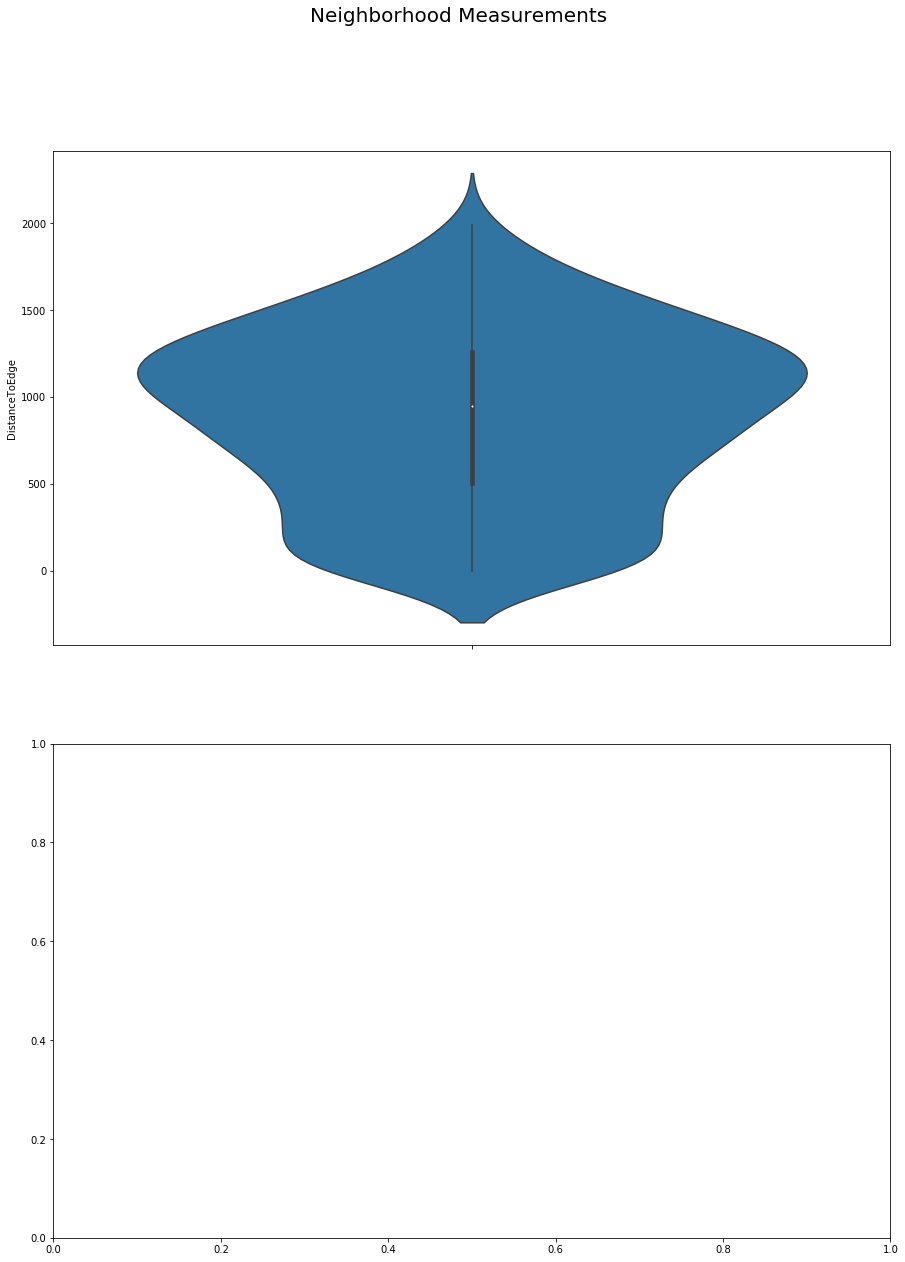

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Neighborhood Measurements', fontsize = 20)
sns.violinplot(y = 'DistanceToEdge', data = site_centroids, ax=ax1[0])

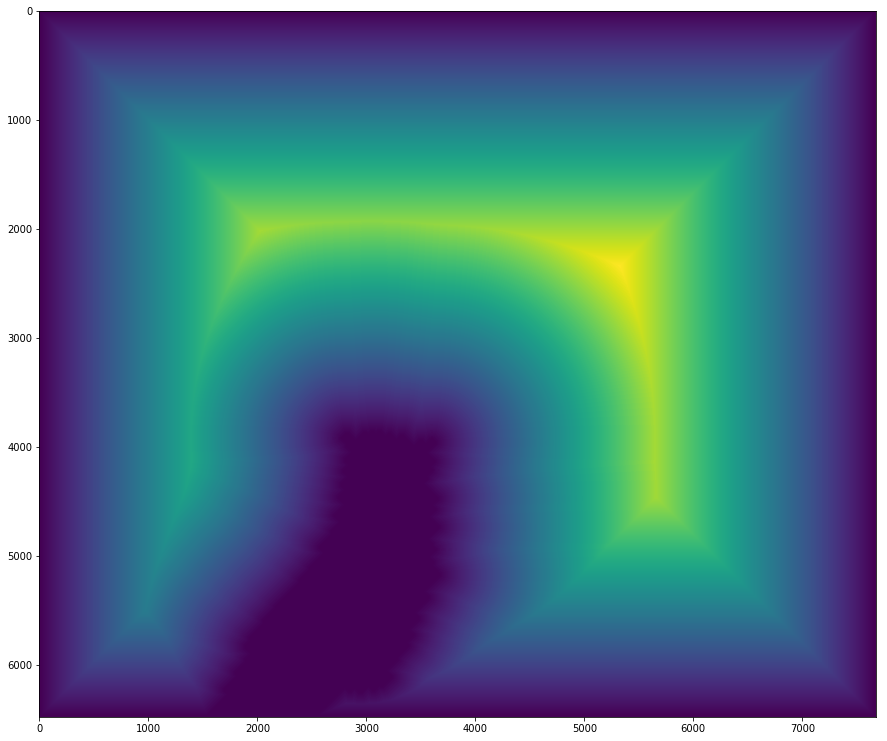

In [52]:
plt.figure(figsize=(15,20))
imgplot = plt.imshow(cell_mask)

# image_size_y=2560
# image_size_x=2160
# plt.figure(figsize=(15,20))
# imgplot = plt.imshow(local_surrounding[image_size_x:(2*image_size_x), image_size_y:(2*image_size_y)])

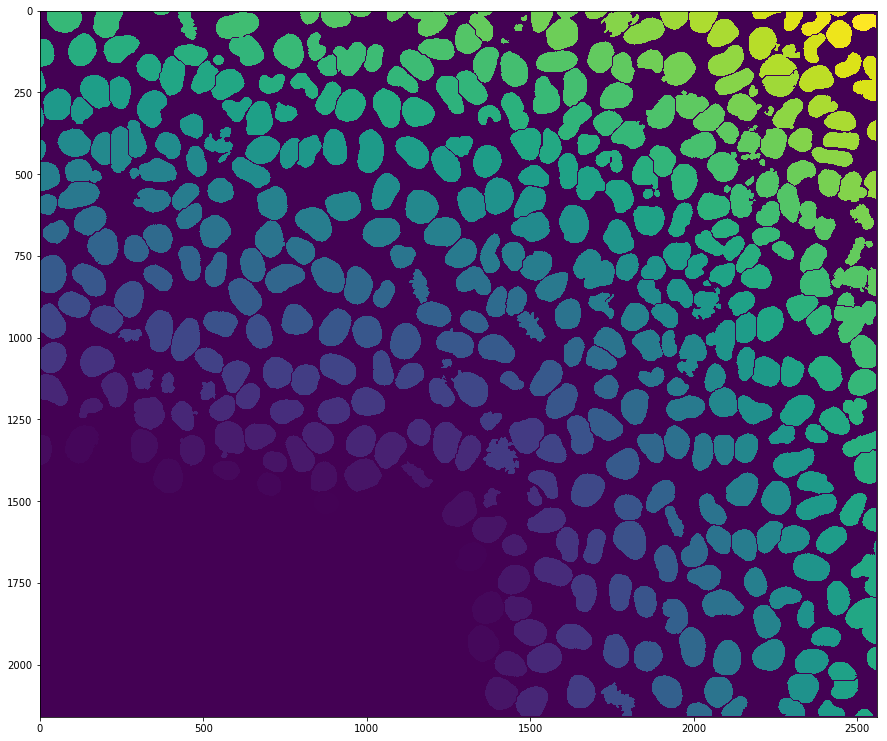

In [16]:
# Local density mapped back on the images
img_width = 2560
img_height = 2160

density_img = np.zeros((img_width, img_height))

# Define site of interest
well_name = 'B02'
well_pos_y = 3
well_pos_x = 2
current_site_bool = (metadata['well_name'] == well_name) & (metadata['well_pos_y'] == well_pos_y)  & (metadata['well_pos_x'] == well_pos_x)

metadata_site = metadata.loc[current_site_bool]
current_site = metadata_site.merge(edge_measurements, on ='mapobject_id')


# Get the segmentation mask from TissueMaps
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190505-WTC-PermeabilizationTest5"
username="joel"
password="123456"
mapobject="Cells"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

segmentation_image = client.download_segmentation_image('Nuclei', plate_name, well_name, well_pos_y, well_pos_x)
# plt.figure(figsize=(15,20))
# imgplot = plt.imshow(segmentation_image)

img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

In [ ]:
# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['DistanceToEdge']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)

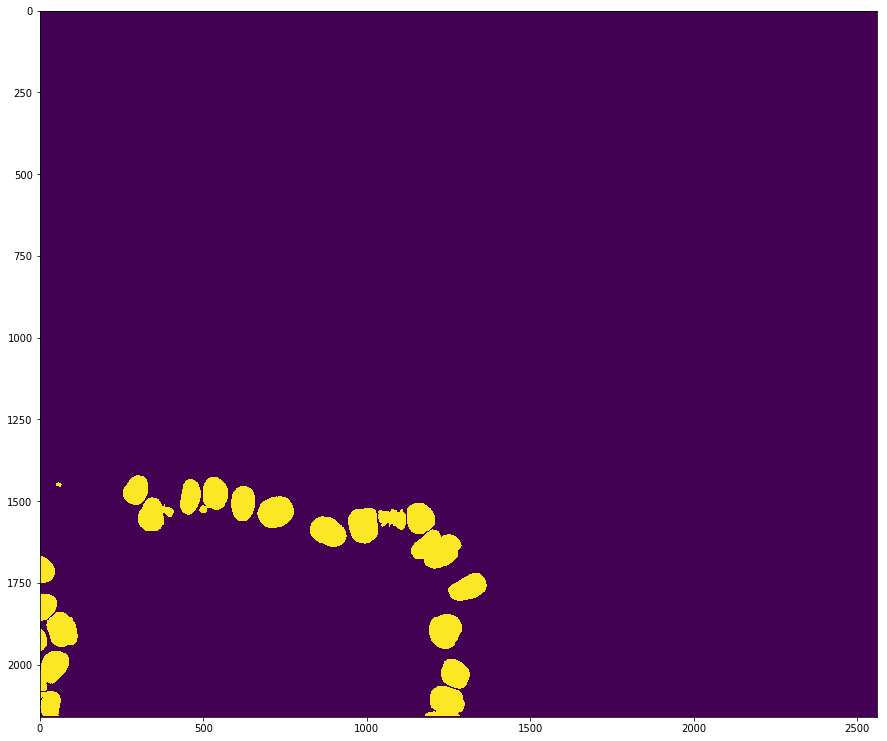

In [17]:
# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['isEdge']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)